In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.notebook import tqdm
import json

In [2]:
# get data from processed data dir
data_dir = '../processed_data/Glue_Ctl_mixed_age_19Oct23_2023_10_19_17_10_46'
# get all cam numbers
cams = [x.split('_')[0] for x in os.listdir(data_dir)]
cams = np.unique(cams)
print(cams)

['cam0' 'cam1' 'cam2' 'cam3' 'cam4' 'cam5' 'cam6' 'cam7']


In [3]:
# cam to expriment+identifier
cam_to_exp = {
    'cam0':'G',
    'cam1':'C',
    'cam2':'B',
    'cam3':'F',
    'cam4':'D',
    'cam5':'A',
    'cam6':'E',
    'cam7':'H'
}
arena_cycle = ['Empty']*4 + ['Proximal']*4 + ['Center']*3 + ['Distal']*4 + ['3/4 PD']*3 + ['1/4 PD']*3 + ['Ends']*3
exceptions = [
    ['D', 12, '1h dry Empty'], # D13 us empty by mistake
]

def get_experiment_name(cam, arena):
    # if cam is A, B, C, D -> 24h dry
    # if cam is E, F, G, H -> 1h dry
    name = ""
    if cam_to_exp[cam] in ['A','B','C','D']:
        name += '24h dry'
    else:
        name += '1h dry'
    name += ' '
    # if cam is A,E -> start at 0
    # if cam is B,F -> start at 6
    # if cam is C,G -> start at 12
    # if cam is D,H -> start at 18 
    # cycle at the end of list
    shift = 0 if cam_to_exp[cam] in ['A','E'] else 6 if cam_to_exp[cam] in ['B','F'] else 12 if cam_to_exp[cam] in ['C','G'] else 18
    shifted_arena_cycle = np.roll(arena_cycle, shift)
    name += shifted_arena_cycle[arena]
    for cam_override, arena_override, name_override in exceptions:
        if cam_to_exp[cam] == cam_override and arena == arena_override:
            name = name_override
    return name

In [4]:
# project to axis
def project_to_axis(distal, proximal, x, y):
    # get angle between distal and proximal
    theta = np.arctan2(distal[1]-proximal[1], distal[0]-proximal[0])
    # get angle between proximal-distal and x,y
    phi = np.arctan2(y-proximal[1], x-proximal[0])
    # get distance from proximal
    d = np.sqrt((x-proximal[0])**2 + (y-proximal[1])**2)
    # project onto axis
    projected = d*np.cos(phi-theta)
    # normalize by arena length
    DP_length = np.sqrt((distal[0]-proximal[0])**2 + (distal[1]-proximal[1])**2)
    projected = projected / DP_length
    return projected

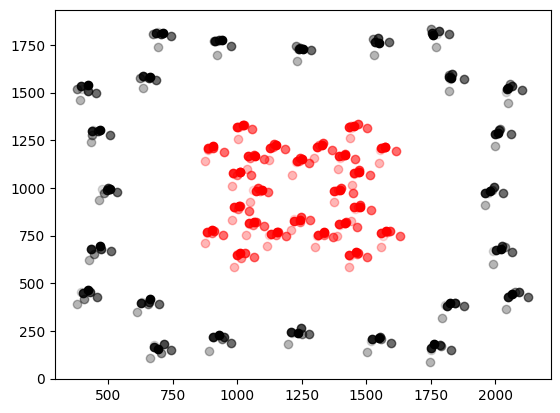

In [5]:
for i in range(8):
    with open(data_dir+f'/cam{i}_background_endpoints.json') as f:
        endpoints = json.load(f)
    for arena in range(24):
        endpoint = endpoints[f'arena_{arena+1}_original']
        plt.plot(endpoint[0][0], endpoint[0][1], 'ok', alpha=i/7)
        plt.plot(endpoint[1][0], endpoint[1][1], 'or', alpha=i/7)

In [6]:
# get endpoints
ALL_DATA = {}
ALL_IDS = {}
ALL_POIS = {}
for camera in range(8):
    with open(data_dir+f'/cam{camera}_background_endpoints.json') as f:
        endpoints = json.load(f)
    with open(data_dir+f'/cam{camera}_background_pois.json') as f:
        pois = json.load(f)
    # get ant locations
    locations = pd.read_csv(data_dir+f'/cam{camera}_ant_locations.csv')
    for arena in tqdm(range(24), desc=f'cam{camera}, all arenas'):
        # get experiment name
        experiment_name = get_experiment_name(f'cam{camera}', arena)
        if experiment_name not in ALL_DATA:
            ALL_DATA[experiment_name] = []
        if experiment_name not in ALL_POIS:
            ALL_POIS[experiment_name] = []
        if experiment_name not in ALL_IDS:
            ALL_IDS[experiment_name] = []

        
        # get endpoint
        endpoint = endpoints[f"arena_{arena+1}_original"]
        distal = endpoint[0]
        proximal = endpoint[1]

        # get ant locations
        ant_x = locations[f"arena_{arena+1}_x"]
        ant_y = locations[f"arena_{arena+1}_y"]

        # get poi
        poi = pois[f'arena_{arena+1}_original']

        # get projected locations
        projections = []
        for x,y in zip(ant_x, ant_y):
            projections.append(project_to_axis(distal, proximal, x, y))
        projections = np.array(projections)
        # clip to 0,1
        projections= np.clip(projections, 0, 1)

        # project the poi
        poises = []
        for x,y in poi:
            poises.append(project_to_axis(distal, proximal, x, y))
        poises = np.array(poises)
        # clip to 0,1
        poises = np.clip(poises, 0, 1)

        # add to ALL_DATA
        ALL_DATA[experiment_name].append(projections)
        ALL_IDS[experiment_name].append((cam_to_exp[f'cam{camera}'], arena+1))
        ALL_POIS[experiment_name].append(poises)
    

cam0, all arenas:   0%|          | 0/24 [00:00<?, ?it/s]

cam1, all arenas:   0%|          | 0/24 [00:00<?, ?it/s]

cam2, all arenas:   0%|          | 0/24 [00:00<?, ?it/s]

cam3, all arenas:   0%|          | 0/24 [00:00<?, ?it/s]

cam4, all arenas:   0%|          | 0/24 [00:00<?, ?it/s]

cam5, all arenas:   0%|          | 0/24 [00:00<?, ?it/s]

cam6, all arenas:   0%|          | 0/24 [00:00<?, ?it/s]

cam7, all arenas:   0%|          | 0/24 [00:00<?, ?it/s]

In [7]:
ALL_DATA.keys()

dict_keys(['1h dry Distal', '1h dry 3/4 PD', '1h dry 1/4 PD', '1h dry Ends', '1h dry Empty', '1h dry Proximal', '1h dry Center', '24h dry Distal', '24h dry 3/4 PD', '24h dry 1/4 PD', '24h dry Ends', '24h dry Empty', '24h dry Proximal', '24h dry Center'])

In [8]:
# Reorder the keys as Empty, Proximal, 1/4 PD, Center, 3/4 PD, Distal, Ends
ALL_DATA = {
    '24h dry Empty': ALL_DATA['24h dry Empty'],
    '1h dry Empty': ALL_DATA['1h dry Empty'],
    '24h dry Proximal': ALL_DATA['24h dry Proximal'],
    '1h dry Proximal': ALL_DATA['1h dry Proximal'],
    '24h dry 1/4 PD': ALL_DATA['24h dry 1/4 PD'],
    '1h dry 1/4 PD': ALL_DATA['1h dry 1/4 PD'],
    '24h dry Center': ALL_DATA['24h dry Center'],
    '1h dry Center': ALL_DATA['1h dry Center'],
    '24h dry 3/4 PD': ALL_DATA['24h dry 3/4 PD'],
    '1h dry 3/4 PD': ALL_DATA['1h dry 3/4 PD'],
    '24h dry Distal': ALL_DATA['24h dry Distal'],
    '1h dry Distal': ALL_DATA['1h dry Distal'],
    '24h dry Ends': ALL_DATA['24h dry Ends'],
    '1h dry Ends': ALL_DATA['1h dry Ends'],
}
ALL_IDS = {
    '24h dry Empty': ALL_IDS['24h dry Empty'],
    '1h dry Empty': ALL_IDS['1h dry Empty'],
    '24h dry Proximal': ALL_IDS['24h dry Proximal'],
    '1h dry Proximal': ALL_IDS['1h dry Proximal'],
    '24h dry 1/4 PD': ALL_IDS['24h dry 1/4 PD'],
    '1h dry 1/4 PD': ALL_IDS['1h dry 1/4 PD'],
    '24h dry Center': ALL_IDS['24h dry Center'],
    '1h dry Center': ALL_IDS['1h dry Center'],
    '24h dry 3/4 PD': ALL_IDS['24h dry 3/4 PD'],
    '1h dry 3/4 PD': ALL_IDS['1h dry 3/4 PD'],
    '24h dry Distal': ALL_IDS['24h dry Distal'],
    '1h dry Distal': ALL_IDS['1h dry Distal'],
    '24h dry Ends': ALL_IDS['24h dry Ends'],
    '1h dry Ends': ALL_IDS['1h dry Ends'],
}
ALL_POIS = {
    '24h dry Empty': ALL_POIS['24h dry Empty'],
    '1h dry Empty': ALL_POIS['1h dry Empty'],
    '24h dry Proximal': ALL_POIS['24h dry Proximal'],
    '1h dry Proximal': ALL_POIS['1h dry Proximal'],
    '24h dry 1/4 PD': ALL_POIS['24h dry 1/4 PD'],
    '1h dry 1/4 PD': ALL_POIS['1h dry 1/4 PD'],
    '24h dry Center': ALL_POIS['24h dry Center'],
    '1h dry Center': ALL_POIS['1h dry Center'],
    '24h dry 3/4 PD': ALL_POIS['24h dry 3/4 PD'],
    '1h dry 3/4 PD': ALL_POIS['1h dry 3/4 PD'],
    '24h dry Distal': ALL_POIS['24h dry Distal'],
    '1h dry Distal': ALL_POIS['1h dry Distal'],
    '24h dry Ends': ALL_POIS['24h dry Ends'],
    '1h dry Ends': ALL_POIS['1h dry Ends'],
}

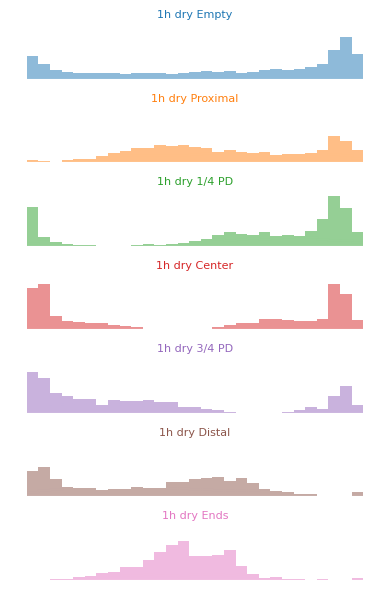

In [15]:
# plot all 1n dry
count = 0
fig,ax = plt.subplots(7,1,figsize=(4,6), sharex=True)
for idx,(name, data) in enumerate(ALL_DATA.items()):
    if '1h dry' in name and '_ID' not in name:
        # plt.figure(figsize=(4,1))
        data = np.array(data)
        # remove the first hour
        data = data[:,:]

        # velocity
        vel = np.diff(data, axis=1)
        bins = np.linspace(0,1,30)
        for i,j in zip(bins[:-1], bins[1:]):
            data_to_plot = np.abs(vel[(data[:,:-1]>=i) & (data[:,:-1]<j)]*5)
            ax[count].plot([i,j], [np.mean(data_to_plot), np.mean(data_to_plot)], color='w', linewidth=1)
        ax[count].set_xlim([-0.05,1.05])
        ax[count].set_ylim([0,0.05])
        ax[count].set_yticks([])
        ax[count].set_xticks([])
        ax[count].spines['top'].set_visible(False)
        ax[count].spines['right'].set_visible(False)
        ax[count].spines['left'].set_visible(False)
        ax[count].spines['bottom'].set_color('white')

        # add title
        ax[count].set_title(name, fontsize=8, color=plt.cm.tab10(count))


        # create a twin axis for the residence time
        ax2 = ax[count].twinx()
        bins = np.linspace(0,1,30)
        ax2.hist(np.concatenate(data), bins=bins, density=True, linewidth=2, color=plt.cm.tab10(count), alpha=0.5)
        ax2.set_xlim([-0.05,1.05])
        ax2.set_ylim([0,5])
        ax2.set_yticks([])
        ax2.set_xticks([])
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['bottom'].set_color('white')

        # vertical lines for pois
        if len(ALL_POIS[name]) != 0:
            pois = np.concatenate(ALL_POIS[name])
            for poi in pois:
                ax[count].axvline(poi, color='w', linestyle='-', linewidth=0.5)
            if 'Empty' in name:
                non_empty_pois = [i for i, x in enumerate(ALL_POIS[name]) if len(x) != 0]
                for x in non_empty_pois:
                    print(ALL_IDS[name][x])
        
        count += 1
plt.xlabel('Normalized distance from proximal end')
plt.tight_layout()
# remove figure background
fig.patch.set_visible(False)
# remove axis background
for ax in fig.axes:
    ax.patch.set_visible(False)
plt.savefig('figures/glue_control/1h_dry_velocity_residence_time.png', transparent=True)
plt.savefig('figures/glue_control/1h_dry_velocity_residence_time.pdf', transparent=True)
plt.show()

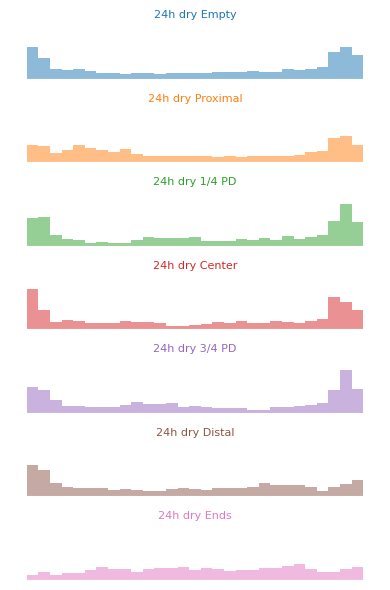

In [16]:
# plot all 1n dry
count = 0
fig,ax = plt.subplots(7,1,figsize=(4,6), sharex=True)
for idx,(name, data) in enumerate(ALL_DATA.items()):
    if '24h dry' in name and '_ID' not in name:
        # plt.figure(figsize=(4,1))
        data = np.array(data)
        # remove the first hour
        data = data[:,:]

        # velocity
        vel = np.diff(data, axis=1)
        bins = np.linspace(0,1,30)
        for i,j in zip(bins[:-1], bins[1:]):
            data_to_plot = np.abs(vel[(data[:,:-1]>=i) & (data[:,:-1]<j)]*5)
            ax[count].plot([i,j], [np.mean(data_to_plot), np.mean(data_to_plot)], color='w', linewidth=1)
        ax[count].set_xlim([-0.05,1.05])
        ax[count].set_ylim([0,0.05])
        ax[count].set_yticks([])
        ax[count].set_xticks([])
        ax[count].spines['top'].set_visible(False)
        ax[count].spines['right'].set_visible(False)
        ax[count].spines['left'].set_visible(False)
        ax[count].spines['bottom'].set_color('white')

        # add title
        ax[count].set_title(name, fontsize=8, color=plt.cm.tab10(count))


        # create a twin axis for the residence time
        ax2 = ax[count].twinx()
        bins = np.linspace(0,1,30)
        ax2.hist(np.concatenate(data), bins=bins, density=True, linewidth=2, color=plt.cm.tab10(count), alpha=0.5)
        ax2.set_xlim([-0.05,1.05])
        ax2.set_ylim([0,5])
        ax2.set_yticks([])
        ax2.set_xticks([])
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['bottom'].set_color('white')

        # vertical lines for pois
        if len(ALL_POIS[name]) != 0:
            pois = np.concatenate(ALL_POIS[name])
            for poi in pois:
                ax[count].axvline(poi, color='w', linestyle='-', linewidth=0.5)
            if 'Empty' in name:
                non_empty_pois = [i for i, x in enumerate(ALL_POIS[name]) if len(x) != 0]
                for x in non_empty_pois:
                    print(ALL_IDS[name][x])
        
        count += 1
plt.xlabel('Normalized distance from proximal end')
plt.tight_layout()
# remove figure background
fig.patch.set_visible(False)
# remove axis background
for ax in fig.axes:
    ax.patch.set_visible(False)
plt.savefig('figures/glue_control/24h_dry_velocity_residence_time.png', transparent=True)
plt.savefig('figures/glue_control/24h_dry_velocity_residence_time.pdf', transparent=True)
plt.show()

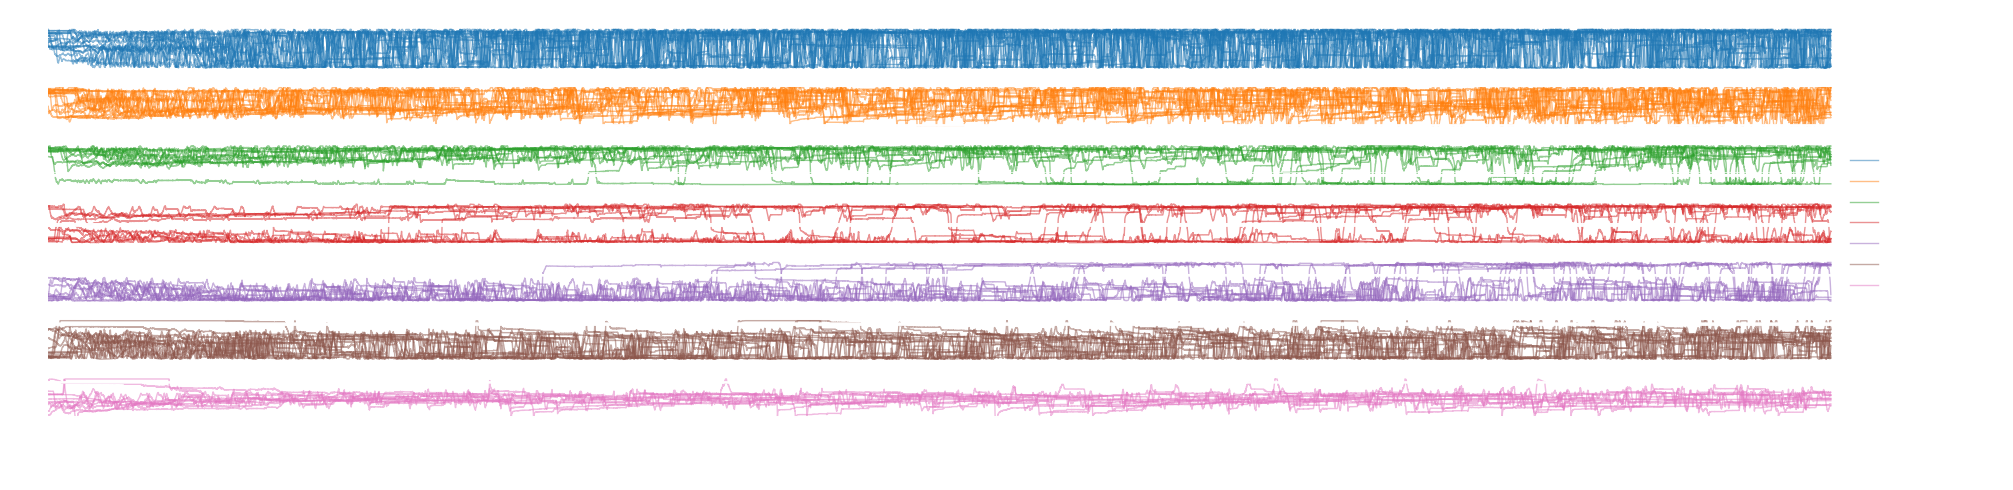

In [17]:
fig = plt.figure(figsize=(20,5))
count = 0
ends = []
for name, data in ALL_DATA.items():
    if '1h dry' in name and '_ID' not in name:
        data = np.array(data)
        for i in range(data.shape[0]):
            plt.plot(data[i]-count*1.5, color=plt.cm.tab10(count), alpha=0.5, linewidth=1, label=name if i==0 else None)
        if len(ALL_POIS[name]) != 0:
            pois = np.concatenate(ALL_POIS[name])
            for poi in pois:
                plt.axhline(poi-count*1.5, color='w', linestyle='-', linewidth=0.5)
        ends.append(0-count*1.5)
        ends.append(1-count*1.5)
        count += 1
# white font legend
legend = plt.legend(loc='center right', bbox_to_anchor=(1.1,0.5), frameon=False)
plt.setp(legend.get_texts(), color='w')
plt.xlabel('Time (s)')
plt.ylabel('Normalized distance from proximal end')
plt.xlim([0,90000])
plt.yticks(ends, ['0','1']*int(len(ends)/2))
plt.box(False)
plt.tight_layout()
fig.patch.set_visible(False)
for ax in fig.axes:
    ax.patch.set_visible(False)
# set axis color 
for spine in plt.gca().spines.values():
    spine.set_color('white')
# set ticks color
plt.tick_params(colors='white')
# set label color
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
plt.savefig('figures/glue_control/1h_dry_all_arenas.png', transparent=True)
plt.savefig('figures/glue_control/1h_dry_all_arenas.pdf', transparent=True)
plt.show()


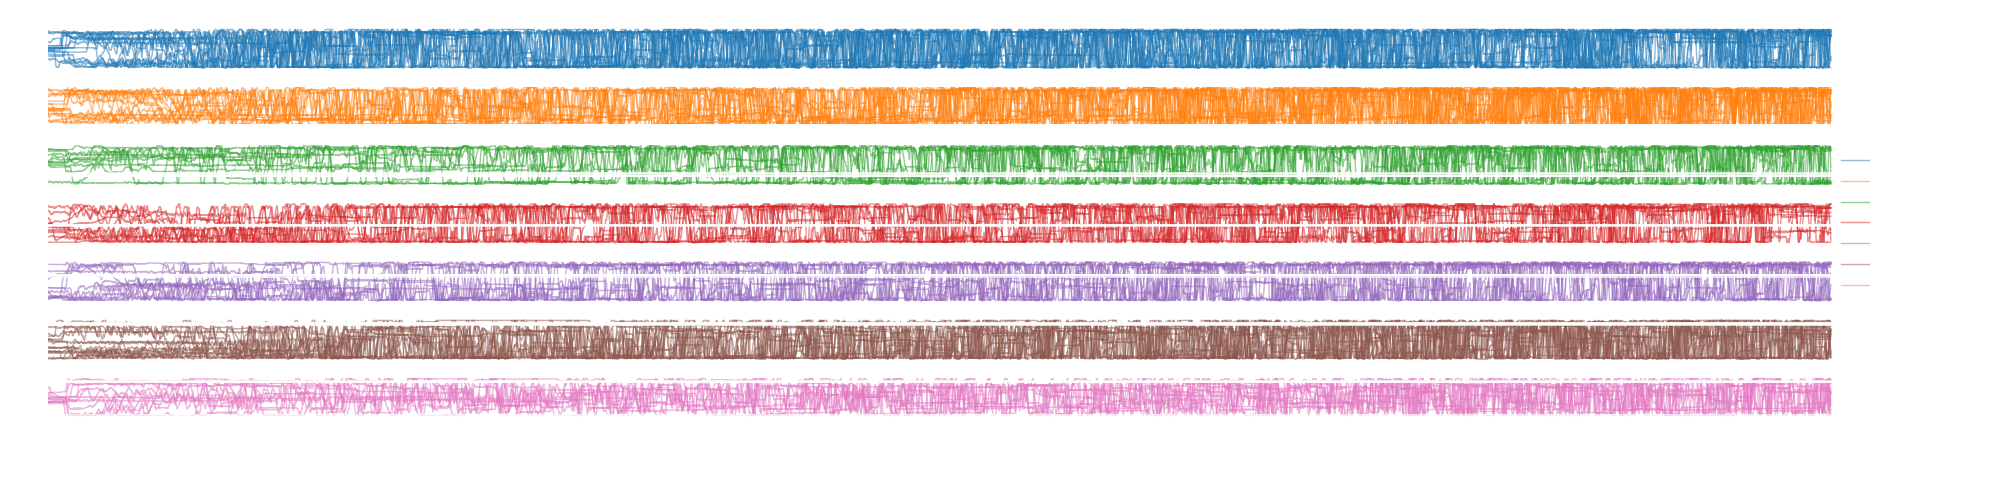

In [18]:
fig = plt.figure(figsize=(20,5))
count = 0
ends = []
for name, data in ALL_DATA.items():
    if '24h dry' in name and '_ID' not in name:
        data = np.array(data)
        for i in range(data.shape[0]):
            plt.plot(data[i]-count*1.5, color=plt.cm.tab10(count), alpha=0.5, linewidth=1, label=name if i==0 else None)
        if len(ALL_POIS[name]) != 0:
            pois = np.concatenate(ALL_POIS[name])
            for poi in pois:
                plt.axhline(poi-count*1.5, color='w', linestyle='-', linewidth=0.5)
        ends.append(0-count*1.5)
        ends.append(1-count*1.5)
        count += 1
# white font legend
legend = plt.legend(loc='center right', bbox_to_anchor=(1.1,0.5), frameon=False)
plt.setp(legend.get_texts(), color='w')
plt.xlabel('Time (s)')
plt.ylabel('Normalized distance from proximal end')
plt.xlim([0,90000])
plt.yticks(ends, ['0','1']*int(len(ends)/2))
plt.box(False)
plt.tight_layout()
fig.patch.set_visible(False)
for ax in fig.axes:
    ax.patch.set_visible(False)
# set axis color 
for spine in plt.gca().spines.values():
    spine.set_color('white')
# set ticks color
plt.tick_params(colors='white')
# set label color
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
plt.savefig('figures/glue_control/24h_dry_all_arenas.png', transparent=True)
plt.savefig('figures/glue_control/24h_dry_all_arenas.pdf', transparent=True)
plt.show()
